In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch
from importlib import reload
import matplotlib.pyplot as plt

from matplotlib.ticker import EngFormatter, MultipleLocator
from matplotlib.dates import DateFormatter
from matplotlib import rc
import itertools

import dask
import dask.array
from ziparchive import read_seamf_zipfile, MultiProcessingZipFile, _read_seamf_zipfile_divisions
from dask import dataframe
import pickle

def transposed_legend(ax, *args, **kws):
    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])

    ncol = kws.get('ncol',1)
    handles, labels = ax.get_legend_handles_labels()
    if len(args) > 0:
        handles = args[0]
        args = args[1:]
    if len(args) > 0:
        labels = args[1]
        args = args[1:]

    if ncol > 1:
        handles = flip(handles, ncol)
        labels = flip(labels, ncol)

    return ax.legend(handles, labels, *args, **kws)

def nearest_datetimes(df, targets):
    return df.index[df.index.get_indexer(
        list(targets),
        method='nearest'
    )]

def trace(dfs: dict, type: str, *columns: str, **inds):
    """ indexing shortcut for SEA data tables.

    Args:
        type: table name key (e.g., 'pfp', 'psd', 'channel_metadata', etc.)
        columns: if specified, the sequence of columns to select (otherwise all)
        inds: the index value to select, keyed on the label name
    """
    ret = dfs[type]

    if len(inds) > 0:
        ret = ret.xs(
            key=tuple(inds.values()),
            level=tuple(inds.keys()),
            drop_level=True
        )

    if len(columns) > 1:
        ret = ret[list(columns)]
    if len(columns) == 1:
        # this is actually a bit dicey, as it forces returning a series..
        # you might deliberately want to pass in a length-1 list to force
        # dataframe
        ret = ret[columns[0]]

    return ret

def plot_pvt_detail(day, freq, detail_datetimes, legend_ax_index=0):
    fig, axs = plt.subplots(nrows=len(detail_datetimes), figsize=(6 + 2/3, 4), layout='constrained', sharey=True)

    detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

    # detail view
    for (label, datetime), ax in zip(detail_datetimes.items(), axs[0:]):
        # remaining index levels will be ('capture_statistic', 'detector')
        pvt_traces = trace(dfs=day, type='pvt', datetime=datetime, frequency=freq)
        ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

        pvt_traces.T.iloc[:,::-1].plot(ax=ax, legend=False)

        ax.get_shared_x_axes().join(*axs[-len(detail_datetimes):])
        ax.grid(True)
    
    axs[legend_ax_index].legend(['RMS detector', 'Peak detector'], loc='best', ncol=2)
    
    ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
    ax.set_xlabel('Capture time elapsed')
    fig.supylabel('Channel power (dBm/10 MHz)', fontsize=10)
    return fig

def plot_psd_detail(day, detail_trace_targets):
    detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

    f0_datetimes = nearest_datetimes(
        trace(day, 'psd', frequency=3.555e9, capture_statistic='max'),
        detail_trace_targets.values()
    )

    psd = trace(day, 'psd')

    fig, axs = plt.subplots(nrows=len(f0_datetimes), figsize=(6+2/3,4), layout='constrained', sharey=True, sharex=True)
    for datetime, label, ax in zip(f0_datetimes, detail_trace_targets.keys(), axs):
        Nfreqs = psd.index.levels[psd.index.names.index('frequency')].shape[0]
        Ntraces = psd.loc[datetime].shape[0]
        sweep = psd.loc[datetime:].iloc[:Nfreqs*Ntraces]

        sweep = sweep.reset_index('datetime', drop=True).unstack('frequency').T
        sweep.index = pd.Index(
            np.array(tuple(sweep.index.values)).sum(axis=1),
            name='Frequency'
            #sort_index(level=['frequency', ])
        )
        sweep.sort_index().iloc[:,::-1].plot(ax=ax, lw=1, legend=False)
        ax.grid(True, which='both', axis='x')
        ax.xaxis.set_major_formatter(EngFormatter(unit='Hz'))
        ax.xaxis.set_minor_locator(MultipleLocator(10e6))

        ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

        if ax == axs[0]:
            fig.legend(ncol=2, loc='lower right')

    fig.supylabel('Power spectral density (dBm/Hz)')

    return fig

def plot_pfp_span_with_detail(day, freq, pfp_indicators, span, detail_datetimes):
    detail_label_style = dict(fontdict={'size': 12}, bbox=dict(boxstyle='square', facecolor='white'), color='black')

    fig, axs = plt.subplots(nrows=len(detail_datetimes)+1, figsize=(6 + 2/3, 6), layout='constrained')

    # mid-scale view
    (
        pfp_indicators.loc[span]
        .plot(ax=axs[0], marker='s', ls=':', lw=1, legend=False)
    )
    for label, index in detail_datetimes.items():
        axs[0].axvline(index, ls=':', color='k')
        axs[0].text(index, -55, label, va='center', ha='center', **detail_label_style)
    axs[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    axs[0].set_xlabel('Local time')
    axs[0].set_ylim([None, pfp_indicators['Frame max (peak detect)'].max()+18])
    axs[0].grid(True)
    fig.legend(ncol=3,columnspacing=0.5, loc='upper right', framealpha=1)
    for t in axs[0].xaxis.get_ticklabels():
        t.set_rotation(0)
        t.set_horizontalalignment('center')

    # detail view
    for (label, datetime), ax in zip(detail_datetimes.items(), axs[1:]):
        # remaining index levels will be ('capture_statistic', 'detector')
        pfp_traces = trace(dfs=day, type='pfp', datetime=datetime, frequency=freq)
        ax.text(0.01, 0.97, label, ha='left', va='top', transform=ax.transAxes, **detail_label_style)

        for detector, color in dict(RMS='C0', peak='C1').items():
            (
                pfp_traces
                .loc['mean',detector.lower()]
                .plot(color=color, ax=ax, lw=1, label=f'{detector} detect: mean')
            )

            ax.fill_between(
                pfp_traces.columns,
                pfp_traces.loc['min', detector.lower()],
                pfp_traces.loc['max', detector.lower()],
                color=color,
                alpha=0.25,
                lw=0,
                label=f'extrema',
                rasterized=True
            )

        pfp_ind = (
            pfp_indicators
            .loc[datetime]
            .loc[['Frame median (RMS detect)','Frame max (peak detect)']]
        )

        for power, color in zip(pfp_ind, ['C0', 'C1']):
            ax.axhline(power, color=color, ls=':')

        # ax.set_xlim([0,10.3e-3])

        ax.get_shared_x_axes().join(*axs[-len(detail_datetimes):])
        ax.get_shared_y_axes().join(*axs[-len(detail_datetimes):])
        ax.grid(True)

        if label == list(detail_datetimes.keys())[0]:
            transposed_legend(ax, markerfirst=False, columnspacing=0.5, ncol=4, loc='upper right')

    ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
    ax.set_xlabel('Time elapsed each reference frame')
    fig.supylabel('Channel power (dBm/10 MHz)', fontsize=10)

    return fig

data_path = Path('data')

rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('lines', linewidth=1)
%config InlineBackend.figure_formats = ['svg']

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [ ]:
@dask.delayed
def select(data: dict, key: str, stub) -> pd.DataFrame:
    if data is None:
        return stub
    
    return data[key]

def zipfile_delayed(data_path, limit_count: int=None, partition_size=40) -> dask.delayed:
    zfile = MultiProcessingZipFile(data_path)
    filelist = [n for n in zfile.namelist() if n.endswith('.sigmf')][:limit_count]
    file_blocks = np.split(filelist, range(0,len(filelist), partition_size))

    @dask.delayed
    def read_partition(files):
        return read_seamf_zipfile(zfile, allowlist=files)

    col_stub = read_seamf_zipfile(zfile, allowlist=filelist[:1])
    col_stub = {k: col_stub[k].iloc[:1] for k in col_stub.keys() if isinstance(col_stub[k], pd.DataFrame)}

    index_divs = _read_seamf_zipfile_divisions(zfile, partition_size, filelist)

    return [read_partition(block) for block in file_blocks], col_stub, index_divs

def zipfile_dask_dfs(data_path, limit_count: int=None, partition_size=40) -> dask.dataframe.DataFrame:
    dicts, col_stubs, index_divs = zipfile_delayed(data_path, limit_count=limit_count, partition_size=partition_size)
    ddfs = {}

    for key in ('psd', 'pfp', 'pvt', 'sweep_metadata', 'channel_metadata'):
        ddfs[key] = dataframe.from_delayed(
            [select(d, key, col_stubs[key]) for d in dicts if d is not None],
            meta=col_stubs[key],
            divisions=index_divs
        )

    return ddfs

partition_size = 40

# Generated the pickle by loading from the zipfile as follows:
# with stopwatch():
#     ddfs = zipfile_dask_dfs(data_path/'NIT-2022-12-13.zip', limit_count=10000, partition_size=partition_size)
#     dfs = ddfs.compute()

    # day = {
    #     k: dfs[k].loc['2022-11-01']
    #     for k in ('psd', 'pfp', 'pvt', 'channel_metadata')
    # }

    # with open('data/2022-11-01.p', 'wb') as fd:
    #     pickle.dump(day, fd)

with stopwatch(), open('data/2022-11-01.p', 'rb') as fd:
    day = pickle.load(fd)

 INFO   2023-02-22 15:51:49.162 • labbench: 0.067 s elapsed


<AxesSubplot:xlabel='datetime', ylabel='Channel power (dBm/10 MHz)'>

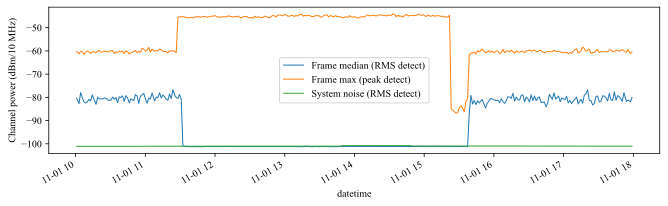

In [ ]:
freq = 3605e6

pfp_indicators = {
    'Frame median (RMS detect)':
        trace(day, 'pfp', frequency=freq, capture_statistic='mean', detector='rms').quantile(0.5, axis=1),
    'Frame max (peak detect)':
        trace(day, 'pfp', frequency=freq, capture_statistic='max', detector='peak').max(axis=1),
    'System noise (RMS detect)':
        trace(day, 'channel_metadata', 'cal_noise_figure_dB', frequency=freq) + -174 + 70 - 1
}

pfp_indicators = pd.concat(pfp_indicators, axis=1)

fig, ax = plt.subplots(figsize=(11,3))
(
    pfp_indicators.loc['2022-11-01 10:00:00':'2022-11-01 18:00:00']
    .plot(ax=ax, ylabel='Channel power (dBm/10 MHz)')
)

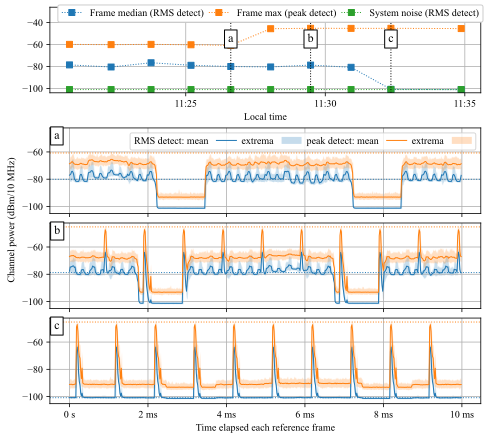

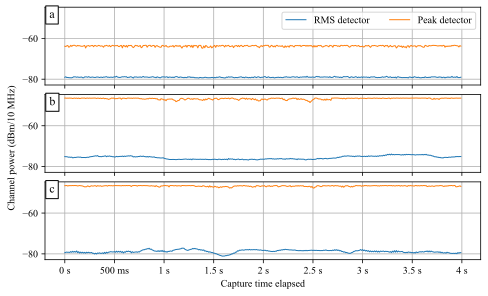

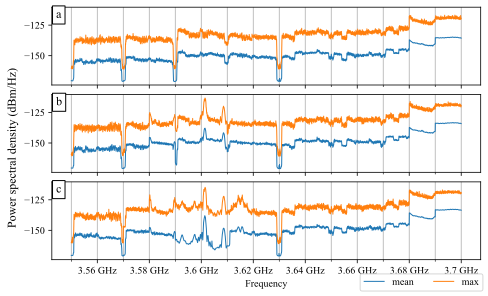

In [ ]:
detail_trace_targets = {'a': '2022-11-01 11:26', 'b': '2022-11-01 11:30', 'c': '2022-11-01 11:33'}
mid_span = slice('2022-11-01 11:20:00','2022-11-01 11:35:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_start.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes)
fig.savefig('nit_event_2022-11_pvt_start.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_start.svg')

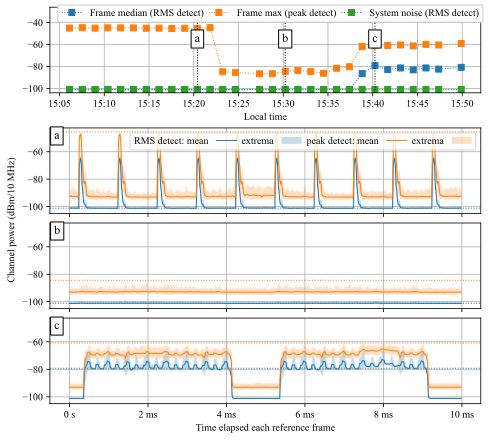

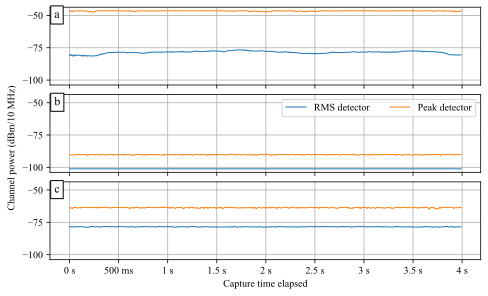

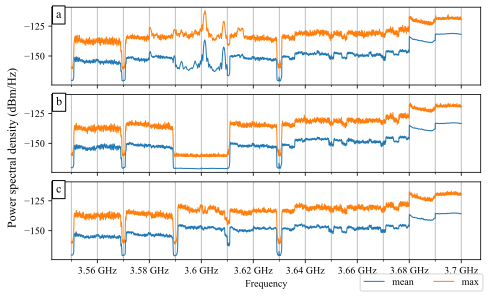

In [ ]:
detail_trace_targets = {'a': '2022-11-01 15:20', 'b': '2022-11-01 15:30', 'c': '2022-11-01 15:40'}
mid_span = slice('2022-11-01 15:05:00','2022-11-01 15:50:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_end.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes, legend_ax_index=1)
plt.savefig('nit_event_2022-11_pvt_end.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_end.svg')